In [5]:
import os
import glob
import pandas as pd

log_dir = 'log'

# M1 和 S1 的 .txt 文件
m1_files = {
    'M1_L23_CC': 'M1_L23_CC.txt',
    'M1_L23_PV': 'M1_L23_PV.txt',
    'M1_L23_SST': 'M1_L23_SST.txt',
    'M1_L23_VIP': 'M1_L23_VIP.txt'
}

s1_files = {
    'S1_L5A_Pyr': 'S1_L5A_Pyr.txt',
    'S1_L5A_SST': 'S1_L5A_SST.txt',
    'S1_L5A_PV': 'S1_L5A_PV.txt',
    'S1_L5B_Pyr': 'S1_L5B_Pyr.txt',
    'S1_L5B_SST': 'S1_L5B_SST.txt',
    'S1_L5B_PV': 'S1_L5B_PV.txt'
}

# --- 读取空间坐标 ---
def read_neuron_file(filepath):
    return pd.read_csv(filepath, sep=r'\s+', header=None, names=['x', 'y', 'z', 'id'])

# --- 读取 spike 数据 ---
def count_spikes_from_multiple_files(prefix):
    """统计所有以 prefix 开头的 .dat 文件中 neuron 的 spike 数"""
    all_files = glob.glob(os.path.join(log_dir, f'{prefix}-*.dat'))
    if not all_files:
        print(f"[Warning] No .dat files found for prefix: {prefix}")
        return pd.Series(dtype=int)

    all_spike_counts = []

    for file in all_files:
        try:
            df = pd.read_csv(file, sep=r'\s+', skiprows=3, names=['id', 'time'])
            counts = df['id'].value_counts()
            all_spike_counts.append(counts)
        except Exception as e:
            print(f"[Error] Failed to read {file}: {e}")

    if all_spike_counts:
        return pd.concat(all_spike_counts, axis=1).fillna(0).sum(axis=1).astype(int).rename('spike_count')
    else:
        return pd.Series(dtype=int)

# --- 读取 M1 ---
m1_data = {}
for key, txt_file in m1_files.items():
    base = txt_file.replace('.txt', '')
    txt_path = os.path.join(log_dir, txt_file)

    df = read_neuron_file(txt_path)
    spike_counts = count_spikes_from_multiple_files(base)
    df = df.merge(spike_counts, how='left', left_on='id', right_index=True).fillna(0)
    df['spike_count'] = df['spike_count'].astype(int)
    m1_data[key] = df

# --- 读取并合并 S1 ---
s1_data = {
    'S1_L5_Pyr': [],
    'S1_L5_SST': [],
    'S1_L5_PV': []
}

for key, txt_file in s1_files.items():
    base = txt_file.replace('.txt', '')
    txt_path = os.path.join(log_dir, txt_file)

    df = read_neuron_file(txt_path)
    spike_counts = count_spikes_from_multiple_files(base)
    df = df.merge(spike_counts, how='left', left_on='id', right_index=True).fillna(0)
    df['spike_count'] = df['spike_count'].astype(int)

    if 'Pyr' in key:
        s1_data['S1_L5_Pyr'].append(df)
    elif 'SST' in key:
        s1_data['S1_L5_SST'].append(df)
    elif 'PV' in key:
        s1_data['S1_L5_PV'].append(df)

# 合并 S1 的 L5A/L5B 同类型神经元
for key in s1_data:
    s1_data[key] = pd.concat(s1_data[key], ignore_index=True)

# --- 输出信息检查 ---
print("\n[M1 neuron types]")
for key, df in m1_data.items():
    print(f"{key}: {len(df)} neurons, total spikes = {df['spike_count'].sum()}")

print("\n[S1 L5 neuron types]")
for key, df in s1_data.items():
    print(f"{key}: {len(df)} neurons, total spikes = {df['spike_count'].sum()}")

# --- 可选保存 CSV ---
# for name, df in {**m1_data, **s1_data}.items():
#     df.to_csv(f'{name}_with_spike_count.csv', index=False)



[M1 neuron types]
M1_L23_CC: 14256 neurons, total spikes = 592
M1_L23_PV: 1280 neurons, total spikes = 6537
M1_L23_SST: 1125 neurons, total spikes = 399
M1_L23_VIP: 1280 neurons, total spikes = 6645

[S1 L5 neuron types]
S1_L5_Pyr: 17860 neurons, total spikes = 3383
S1_L5_SST: 1536 neurons, total spikes = 1783
S1_L5_PV: 2167 neurons, total spikes = 13650


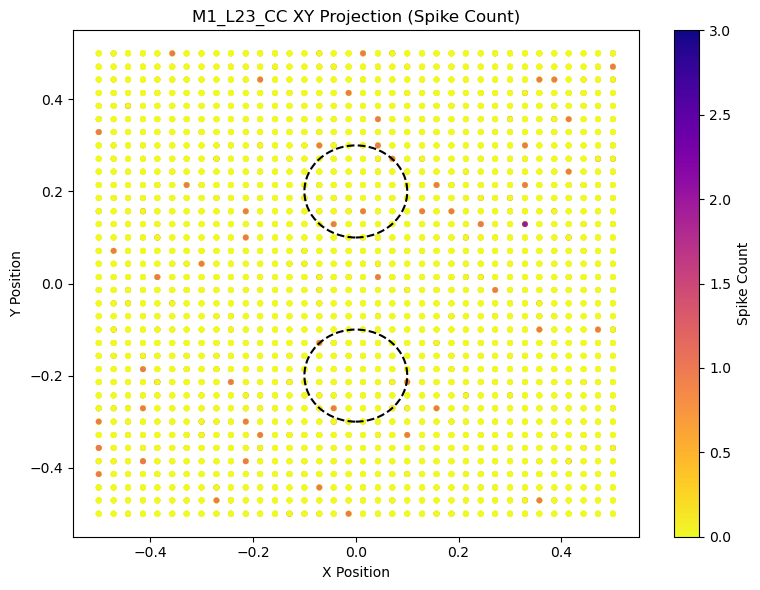

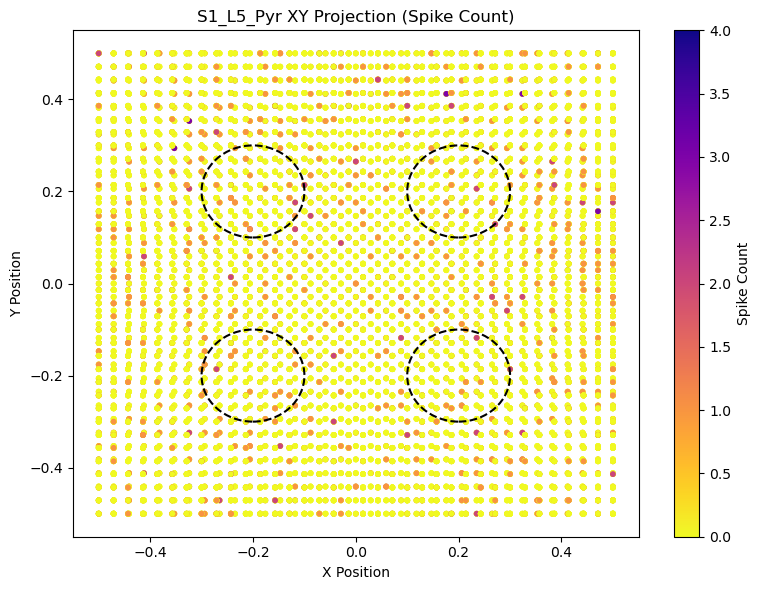

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_xy_spike_density(df, title, stim_centers=None, stim_radius=0.10, save_path=None):
    """
    在 XY 平面绘制神经元分布图，并标注刺激圆圈。
    """
    plt.style.use('default')

    fig, ax = plt.subplots(figsize=(8, 6))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    # 散点图
    sc = ax.scatter(
        df['x'], df['y'],
        c=df['spike_count'],
        cmap='plasma_r',  # 彩色：越高越深
        s=10
    )

    # 刺激圆圈
    if stim_centers:
        for (cx, cy) in stim_centers:
            circle = patches.Circle(
                (cx, cy), stim_radius,
                edgecolor='black',
                facecolor='none',
                linewidth=1.5,
                linestyle='--'
            )
            ax.add_patch(circle)

    # 图设置
    plt.colorbar(sc, ax=ax, label='Spike Count')
    ax.set_xlabel('X Position', color='black')
    ax.set_ylabel('Y Position', color='black')
    ax.set_title(title, color='black')
    ax.grid(False)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, facecolor='white')
    plt.show()


# --- 刺激参数 ---
hex_radius = 0.10
s1_circle_center = [[0.2, 0.2], [-0.2, -0.2], [0.2, -0.2], [-0.2, 0.2]]
m1_circle_center = [[0, 0.2], [0, -0.2]]

# --- 画 M1 图，只标 M1 圆 ---
plot_xy_spike_density(
    df=m1_data['M1_L23_CC'],
    title='M1_L23_CC XY Projection (Spike Count)',
    stim_centers=m1_circle_center,
    stim_radius=hex_radius
)

# --- 画 S1 图，只标 S1 圆 ---
plot_xy_spike_density(
    df=s1_data['S1_L5_Pyr'],
    title='S1_L5_Pyr XY Projection (Spike Count)',
    stim_centers=s1_circle_center,
    stim_radius=hex_radius
)
